# Basic Movie Recommendation Engine

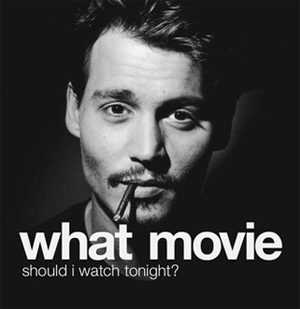

In [2]:
from IPython.display import Image
Image(filename='picture.jpg')

In [3]:
import os
os.getcwd()
os.chdir('E:\Data Science Projects\movie recommed')

In [4]:
#Import all the dependencies

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import SVD
from surprise import reader
from surprise import dataset
from surprise import evaluate

In [5]:
# Importing the data
meta_data = pd.read_csv('movies_metadata.csv')
print(meta_data.shape) #(45466, 24)
meta_data.head()

C:\Users\all\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
# Basic evaluation of dataset
print(meta_data.isnull().sum())
print(meta_data.dtypes)

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64
adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_lan

In [7]:
# Cleaning 'genres' column and storing the info in the new column 'genre_list'
meta_data['genre_list'] = meta_data.genres.apply(literal_eval).apply(lambda x: [i['name'] for i in x])
meta_data['genre_list'].head()                                                                   

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genre_list, dtype: object

# Simple Recommendation System

I will use weighted rating formula to construct chart top 250 movies of all time. Mathematically, formula is represented as follows:

Weighted Rating (WR) =  (v/v+m)R+(m/v+m)C
where,

v is the number of votes for the movie
m is the minimum votes required to be listed in the chart
R is the average rating of the movie
C is the mean vote across the whole report

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. 

In [8]:
m = meta_data.vote_count.quantile(0.95)
print(m)
C = meta_data['vote_average'].mean()
print(C)

434.0
5.618207215133889


In [9]:
# movies having more votes than at least 95% of the movies in the list.
qualified_movies = meta_data[meta_data.vote_count>=m].copy()

In [10]:
# calculating the score of each moviebased on the formula
def score(df,m=m,C=C):
    v = df['vote_count']
    R = df['vote_average']
    return (v/(v+m)*R) + (m/(v+m)*C)

qualified_movies['score'] = qualified_movies.apply(score, axis=1)
qualified_movies['score'].head()

0     7.545529
1     6.704602
5     7.310561
9     6.338269
15    7.267137
Name: score, dtype: float64

In [12]:
# Converting list to string for ease of processing
qualified_movies['genre_string']=qualified_movies['genre_list'].apply(', '.join)
# top 10 movies
top10 = qualified_movies.sort_values(by='score',ascending = False).head(10).title
top10

314      The Shawshank Redemption
834                 The Godfather
12481             The Dark Knight
2843                   Fight Club
292                  Pulp Fiction
351                  Forrest Gump
522              Schindler's List
23673                    Whiplash
5481                Spirited Away
1154      The Empire Strikes Back
Name: title, dtype: object

In [14]:
# top movies by genre
def top10_by_genre(genre):
    new = qualified_movies[qualified_movies['genre_string'].str.contains(genre)].copy()
    return new.sort_values(by='score',ascending = False).head(10)[['title','genre_list','vote_count','vote_average','score']]
top10_by_genre('Drama')

,title,genre_list,vote_count,vote_average,score
314,The Shawshank Redemption,"[Drama, Crime]",8358.0,8.5,8.357746
834,The Godfather,"[Drama, Crime]",6024.0,8.5,8.306334
12481,The Dark Knight,"[Drama, Action, Crime, Thriller]",12269.0,8.3,8.208376
2843,Fight Club,[Drama],9678.0,8.3,8.184899
351,Forrest Gump,"[Comedy, Drama, Romance]",8147.0,8.2,8.069421
522,Schindler's List,"[Drama, History, War]",4436.0,8.3,8.061007
23673,Whiplash,[Drama],4376.0,8.3,8.058025
2211,Life Is Beautiful,"[Comedy, Drama]",3643.0,8.3,8.014521
18465,The Intouchables,"[Drama, Comedy]",5410.0,8.2,8.008265
22879,Interstellar,"[Adventure, Drama, Science Fiction]",11187.0,8.1,8.007315


# CONTENT BASED RECOMMENDATION

In [17]:
# Getting additional data
credit = pd.read_csv('credits.csv')
credit.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [18]:
keywords = pd.read_csv('keywords.csv')  
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [20]:
# removing faulty data
invalid_ids = meta_data[meta_data['id'].str.contains('-')].index
meta_data.drop(invalid_ids,inplace=True)

In [21]:
# changing id datatype to int
meta_data['id'] = meta_data['id'].astype('int64')

In [22]:
# merge data                    
meta_data = meta_data.merge(credit, on='id')
meta_data = meta_data.merge(keywords, on='id')

In [23]:
# crew and cast size
meta_data['crew_size'] = meta_data['crew'].apply(literal_eval).apply(lambda x: len(x))
meta_data['cast_size'] = meta_data['cast'].apply(literal_eval).apply(lambda x: len(x))


In [24]:
# Getting director name
meta_data['director'] = meta_data.crew.apply(literal_eval).apply(lambda x: x[0]['name'] if len(x)!=0 else np.nan)


In [42]:
# Getting top 3 cast members
meta_data['cast'] = meta_data['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
# Getting key words
meta_data['keywords'] = meta_data['keywords'].apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [43]:
# Data cleaning
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
        
meta_data['director'] = meta_data['director'].apply(clean_data)
meta_data['cast'] = meta_data['cast'].apply(clean_data)
meta_data['genre_list'] = meta_data['genre_list'].apply(clean_data)
meta_data['keywords'] = meta_data['keywords'].apply(clean_data)


In [44]:
# combining all the useful features into one column for ease
def combine(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genre_list'])
# Create a new soup feature
meta_data['combine'] = meta_data.apply(combine, axis=1)

In [45]:
#Convert text of useful features to a matrix of token counts
countV = CountVectorizer(stop_words='english')
# taking first 1000 records only due to memory limitations
countM_small = countV.fit_transform(meta_data['combine'][:1000])

In [46]:
# Calculating dot products of the vectors
cosine_simi_small = cosine_similarity(countM_small, countM_small)

In [55]:
#resetting the current index to the titles of the movies
meta_data = meta_data.reset_index()
indices = pd.Series(meta_data.index, index=meta_data['title'])

In [48]:
# Getting content based recommendation of movies like "Jumaji"
def get_recommendations(title, cosine_sim=cosine_simi_small):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return meta_data['title'].iloc[movie_indices]

get_recommendations('Jumanji')

651       James and the Giant Peach
500                           North
622         All Dogs Go to Heaven 2
552                  The Pagemaster
240                Gumby: The Movie
59       The Indian in the Cupboard
254    A Kid in King Arthur's Court
581                         Aladdin
541               Super Mario Bros.
239                           Gordy
Name: title, dtype: object

# Collaborative Filtering

Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

In [67]:
ratings = pd.read_csv('ratings_small.csv')
reader = reader.Reader()
data = dataset.Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [57]:
data.split(n_folds=5)

In [58]:
#using Singular Value Decomposition (SVD) from surprise library
svd = SVD()
# minimise RMSE (Root Mean Square Error) and give great recommendations.
evaluate(svd, data, measures=['RMSE', 'MAE'])


C:\Users\all\Anaconda3\lib\site-packages\surprise\evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
C:\Users\all\Anaconda3\lib\site-packages\surprise\dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8983
MAE:  0.6905
------------
Fold 2
RMSE: 0.8940
MAE:  0.6856
------------
Fold 3
RMSE: 0.9017
MAE:  0.6986
------------
Fold 4
RMSE: 0.9052
MAE:  0.6968
------------
Fold 5
RMSE: 0.8830
MAE:  0.6785
------------
------------
Mean RMSE: 0.8964
Mean MAE : 0.6900
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.69047642002693099,
                             0.68556654589441834,
                             0.69857341146437923,
                             0.69683615202537053,
                             0.67852300148693689],
                            'rmse': [0.89828636817510188,
                             0.89400847568612962,
                             0.90172001593494544,
                             0.90515702880998483,
                             0.88302564794738625]})

In [62]:
trainset = data.build_full_trainset()
svd.train(trainset)

C:\Users\all\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


In [63]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [64]:
svd.predict(1, 31, 3)  # Predicted rating comes out to be: 2.5224042196177638

Prediction(uid=1, iid=31, r_ui=3, est=2.5224042196177638, details={'was_impossible': False})

In [65]:
svd.predict(1, 1953, 3)  # Predicted rating comes out to be : 3.2317935191962475

Prediction(uid=1, iid=1953, r_ui=3, est=3.2317935191962475, details={'was_impossible': False})